In [1]:
# General comments when using this skyfield package:
#
#- baricentric: barycentric = earth.at(t) or dws.at(t)
#  position of earth center or dws or any other point in space measured from the Solar System’s center of mass (without any corrections)
#- astrometric = barycentric.observe(moon)
#  when you use astrometric you can observe moon from earth center or dws at time t,
#  it applies the effect of light travel time.
#  i.e, on Earth we see the Moon where it was about 1.3 seconds ago, the Sun where it was 8 minutes ago.
#  Recently, it has been confirmed that "gravity" (according to Einstein) travel at the speed of light,
#  so if the sun "disappears" we will still feel gravity as waves arriving during 8 minutes, read:
#  https://www.forbes.com/sites/startswithabang/2020/12/18/ask-ethan-why-doesnt-gravity-happen-instantly/?sh=343391f17fd2
#- apparent = astrometric.apparent()
#  correct aberration of light produced by the observer’s own motion through space, and the gravitational deflection
#  light that passes close to masses like the Sun and Jupiter — and, for an observer on the Earth’s surface, for deflection produced by the Earth’s own gravity.
#  These corrections seem to be important when looking into the space to find an object, but not
#  for the gravitational effects on tides; however, the only way to get azimuth and altitude in this package is using .apparent()
#- altitude,azimuth = apparent.altaz()
#  get altitude and azimuth, can only be called with .apparent()

#Tutorials:
#https://rhodesmill.org/skyfield/positions.html#quick-reference
#
#https://rhodesmill.org/skyfield/time.html#downloading-timescale-files
#https://rhodesmill.org/skyfield/api-time.html#calendar-date
#https://rhodesmill.org/skyfield/example-plots.html
#https://rhodesmill.org/skyfield/positions.html
#https://rhodesmill.org/skyfield/

from skyfield.api import load
from skyfield.api import N, S, W, E, wgs84
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr
import dask as da
import pandas as pd
import scipy.fftpack as fftt #just for checking peaks of signals
import datetime 

In [ ]:
#Average and std every M2----
#
#Conclusion 
#Using data every integer M2=44714s, or average-M2, or starting from different initial time: 
# - induce a long term lag in the 36-years data of 1.3h in comparison with the more accurate M2 (44714.16432s) that dont.
# - the effect of the appox integer M2 on the angular positions and distance depends when you start and on the avg.
# - it is supposed this is a real effect in our simulation, as we deployed particles every integer M2.
#Data to be used:
# - mean and std of position and distances, as well as the initial values at the begin of the interval

In [138]:
#----------
home_dir="/export/lv4/user/jfajardourbina/"
ml_dir=f"{home_dir}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/"
dir_displacement="net_displacement/"
#
m2=int(12.42*3600+2) #period in seconds
dt_fac_m2_sec=283*2 #get astronomical data every 566s = 9.43 min (factor of m2=44714)
#
#paths for output data
dir_post_proc_data=f"{ml_dir}post_proc_data/" #to save wind interp files
dir_tides="tides_skyfield/"
file_tides="skyfield_distance_azimuth_altitude_avg_std_M2_for_convlstm.nc"

In [139]:
#get time from net displacement files---
files_displacement=sorted(glob.glob(f'{dir_post_proc_data}{dir_displacement}*.nc',recursive=True))
#concat all the files
dsdis=xr.open_mfdataset(files_displacement,concat_dim="time",combine='nested',parallel='True',chunks={'time': -1},
                        decode_cf=True, decode_times=True)
time_dis=dsdis.time.values
dsdis.close(); del dsdis
#
nt_dis=len(time_dis) #=25290 deployments
#
#times to get astronomical info and then perform std and avg in the m2 interval---
tini=time_dis[0]; tinip=pd.to_datetime(tini)
tend=time_dis[-1]+np.timedelta64(m2-dt_fac_m2_sec,'s'); tendp=pd.to_datetime(tend) #1 extra m2 to have the full interval for the last deployment but without the last point
dt=dt_fac_m2_sec/86400 #dt_fac_m2_sec = 566s = 9.43 min (factor of m2=44714)
print("deployments = ",nt_dis)

deployments =  25290


In [140]:
#Create a skyfield timescale---
ts = load.timescale()

In [141]:
#checking uniform and non-uniform(as UTC) time scales---

#there are 3 uniform time scales that use relative times to a certain epoch (Julian date)
#so, this is better for skyfield computations because what only matters is the time difference.
#When was Julian date zero for the default time scale (terrestrial time: TT) of skyfield?
bc_4714 = -4713
t = ts.tt(bc_4714, 11, 24, 12)  #get a Time object from a terrestrial time (TT) calendar (year,month,...) 
print(t.tt) # = 0 date
#get the julian date related to the above 0, for the other 2 scales:
print(t.tdb*86400) # Barycentric Dynamical Time (TDB) = TT+0.00190seconds
print(t.tai*86400) # International Atomic Time (TAI) = TT-32.184seconds

#dates using skyfield utc are referenced using time coordinate terrestrial time (TT) scale by default
# 2014 January 1 00:00 UTC expressed as different Julian dates
t = ts.utc(2014, 1, 1)
print(t) #Time object reference with default TT scale, as you could see in the print
print(f"TT = {t.tt*86400}") #same as above
print(f"TDB = {t.tdb*86400}") # Barycentric Dynamical Time (TDB) = TT+0.00190seconds
print(f"TAI = {t.tai*86400}") # International Atomic Time (TAI)  = TT-32.184seconds

0.0
0.0018987350060228891
-32.18399999999981
<Time tt=2456658.5007775924>
TT = 212255294467.184
TDB = 212255294467.18393
TAI = 212255294435.0


In [142]:
#Load the JPL ephemeris DE421 (covers 1900-2050)---
#An ephemeris from the JPL provides Sun, Moon, planets and Earth positions.
eph = load('de421.bsp')
earth, moon, sun = eph['earth'], eph['moon'], eph['sun']

In [143]:
#create a time vector with skyfield--- 

#find total seconds between init and final date:
ti=datetime.datetime(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
te=datetime.datetime(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
tot_sec=(te-ti).total_seconds() #total elapsed seconds
#
#build Time objects from an UTC calendar date, using the init UTC date and the elapsed seconds since this initial date
times=ts.utc(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,np.arange(tinip.second,tot_sec+1e-5,dt_fac_m2_sec))
dtt=np.diff(times.tt) #=dt=9.43min
print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times.shape)
#
#check the first 2 and the last 2 times of the vector built with skynet
#there are 17 leap seconds from 1980-2015 (for us and accord to wikipedia), but it does not matter since after referencing the first date, then it is only used the elapsed time
#we have the same time difference (elapsed time in seconds) for:
# - tot_sec = dt_fac_m2_sec*(len(times)-1) = the actual elapsed seconds
# - times[-1].tt-times[0].tt)*86400
# - np.sum(np.diff(times.tt))*86400
# - and also assuming that the init and final dates are in a TT calendar (which is not ok since they are in a UTC calendar)
print(tinip,times[[0,1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
print(tendp,times[[-2,-1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
np.sum(np.diff(times.tt))*86400,(times[-1].tt-times[0].tt)*86400,tot_sec,dt_fac_m2_sec*(len(times)-1)

566 565.9999877214432 565.9999999999953 566.0000279545784 (1997910,)
1980-01-01 08:20:00 ['1980-01-01 08:20:00', '1980-01-01 08:29:26']
2015-11-01 12:01:34 ['2015-11-01 11:51:51', '2015-11-01 12:01:17']


(1130816493.999991, 1130816493.999991, 1130816494.0, 1130816494)

In [144]:
#This is not ok, because we are feeding ts.tt with our utc calendar dates,
#ts.tt requires as input TT calendar dates, which we dont have,
#However, the elapsed time is the same as above
#
times2=ts.tt(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,np.arange(tinip.second,tot_sec+1e-5,dt_fac_m2_sec))
dtt2=np.diff(times2.tt) #=dt=9.43min
print(dt_fac_m2_sec,dtt2.min()*86400,dtt2.mean()*86400,dtt2.max()*86400,times2.shape)
print(tinip,times2[[0,1]].tt_strftime('%Y-%m-%d %H:%M:%S'))
print(tendp,times2[[-2,-1]].tt_strftime('%Y-%m-%d %H:%M:%S'))
np.sum(np.diff(times2.tt))*86400,(times2[-1].tt-times2[0].tt)*86400,tot_sec,dt_fac_m2_sec*(len(times2)-1)

566 565.9999877214432 566.0000000000156 566.0000279545784 (1997910,)
1980-01-01 08:20:00 ['1980-01-01 08:20:00', '1980-01-01 08:29:26']
2015-11-01 12:01:34 ['2015-11-01 11:52:08', '2015-11-01 12:01:34']


(1130816494.000031, 1130816494.000031, 1130816494.0, 1130816494)

In [9]:
# #the same as above but a bit more confusing because we also have to use ts.tt_jd() instead of only ts.utc()

# #first build initial and final Time objects from an UTC calendar date (our data is in UTC)
# tinis=ts.utc(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
# tends=ts.utc(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
# #now build all Times
# #.tt_jd(): builds Time objects from Terrestrial Time TT Julian dates, so use .tt from above dates 
# times=ts.tt_jd(np.arange(tinis.tt*86400,tends.tt*86400+1e-5,dt_fac_m2_sec)/86400) 
# #times=ts.tt_jd(np.arange(tinis.tt,tends.tt+1e-5,dt)) #if we use this due to rounding issues of dt we will not have the correct elapsed time
# dtt=np.diff(times.tt) #=dt=9.43min
# print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times.shape)

# #check the first 2 and the last 2 times of the vector built with skynet
# #there are 17 leap seconds from 1980-2015 (for us and accord to wikipedia), but it does not matter since after referencing the first date, then it is only used the elapsed time
# #we have the same time difference (elapsed time in seconds) for:
# # - dt_fac_m2_sec*(len(times)-1) = the actual elapsed seconds
# # - times[-1].tt-times[0].tt)*86400
# # - np.sum(np.diff(times.tt))*86400
# # - and also assuming that the init and final dates are in a TT calendar (which is not ok since they are in a UTC calendar)
# print(tinip,tinis.utc_strftime('%Y-%m-%d %H:%M:%S'),times[[0,1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
# print(tendp,tends.utc_strftime('%Y-%m-%d %H:%M:%S'),times[[-2,-1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
# print(np.sum(np.diff(times.tt))*86400,(times[-1].tt-times[0].tt)*86400,(tends.tt-tinis.tt)*86400,dt_fac_m2_sec*(len(times)-1))
# print()

# #This is not ok, because we are feeding ts.tt with our utc calendar dates,
# #ts.tt requires as input TT calendar dates, which we dont have,
# #However, the elapsed time is the same as above

# t1=ts.tt(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
# t2=ts.tt(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
# times2=ts.tt_jd(np.arange(t1.tt*86400,t2.tt*86400+1,dt_fac_m2_sec)/86400) 
# dtt=np.diff(times2.tt) #=dt=9.43min
# print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times2.shape)
# print(tinip,times2[[0,1]].tt_strftime('%Y-%m-%d %H:%M:%S'))
# print(tendp,times2[[-2,-1]].tt_strftime('%Y-%m-%d %H:%M:%S'))
# print(np.sum(np.diff(times2.tt))*86400,(times2[-1].tt-times2[0].tt)*86400,(t2.tt-t1.tt)*86400,dt_fac_m2_sec*(len(times2)-1))

In [145]:
#convert to datetime using utc_datetime skyfield function
times_datetime=times.utc_datetime()
print(times_datetime,times_datetime.shape)
print()

#using numpy (it does not take into account leap seconds), but the size of the array is the same as skyfield
#the elapsed time is also the same
times_np=np.arange(tini,tend+np.timedelta64(1,'s'),dt_fac_m2_sec,dtype='datetime64[s]') 
print(times_np,times_np.shape)

[datetime.datetime(1980, 1, 1, 8, 20, tzinfo=datetime.timezone.utc)
 datetime.datetime(1980, 1, 1, 8, 29, 26, tzinfo=datetime.timezone.utc)
 datetime.datetime(1980, 1, 1, 8, 38, 52, tzinfo=datetime.timezone.utc)
 ...
 datetime.datetime(2015, 11, 1, 11, 42, 25, tzinfo=datetime.timezone.utc)
 datetime.datetime(2015, 11, 1, 11, 51, 51, tzinfo=datetime.timezone.utc)
 datetime.datetime(2015, 11, 1, 12, 1, 17, tzinfo=datetime.timezone.utc)] (1997910,)

['1980-01-01T08:20:00' '1980-01-01T08:29:26' '1980-01-01T08:38:52' ...
 '2015-11-01T11:42:42' '2015-11-01T11:52:08' '2015-11-01T12:01:34'] (1997910,)


In [146]:
#check time dimensions
nt_interval=int(m2/dt_fac_m2_sec) #points in the m2 interval (right border of interval open)
nt_dep=len(times_np)//nt_interval #=len(t_dep), final shape after mean or std in the m2 interval. 
nt_interval,nt_dep,nt_dis,nt_interval*nt_dep

(79, 25290, 25290, 1997910)

In [12]:
#Computations in Topocentric coordinates-----
#
#specific to your location on the Earth’s surface
lat=53.0; lon=4.5 #in front of Texel
dws = earth + wgs84.latlon(lat*N,lon*E) 

### Moon

In [13]:
%%time
#MOON----
#3.5minutes from 1980-2016
astro_moon = dws.at(times).observe(moon)
#- altitude or elevation (deg,min,sec): -90:90deg
#- azimuth (deg,min,sec): 0:360deg
#- distance (au or km): 1au (astronomical unit) = 1.496e8km
alt_moon, az_moon, dist_moon = astro_moon.apparent().altaz()
print(alt_moon)
print(az_moon)
#print(dist_moon)
#
#convert above values to arrays---
#altitude_moon_rad=alt_moon.radians
altitude_moon_deg=alt_moon.degrees
#azimuth_moon_rad=alt_moon.radians
azimuth_moon_deg=az_moon.degrees
distance_moon_au = dist_moon.au #AU units
#distance_moon_km = dist_moon.km #km units
#distance_moon_km2 = dist_moon2.km #km units
#a=distance_moon_km-distance_moon_km2 #almost the same distnace when using .radec
print(altitude_moon_deg[[0,-1]])
print(azimuth_moon_deg[[0,-1]])
print(distance_moon_au[[0,-1]])
#print(distance_moon_km[[0,-1]])

1997910 values from -11deg 54' 44.2" to -03deg 19' 32.1"
1997910 values from 323deg 38' 39.0" to 303deg 54' 07.9"
[-11.91226487  -3.32559382]
[323.64415874 303.90218954]
[0.00259017 0.00256895]
CPU times: user 5min 22s, sys: 33.4 s, total: 5min 55s
Wall time: 3min 30s


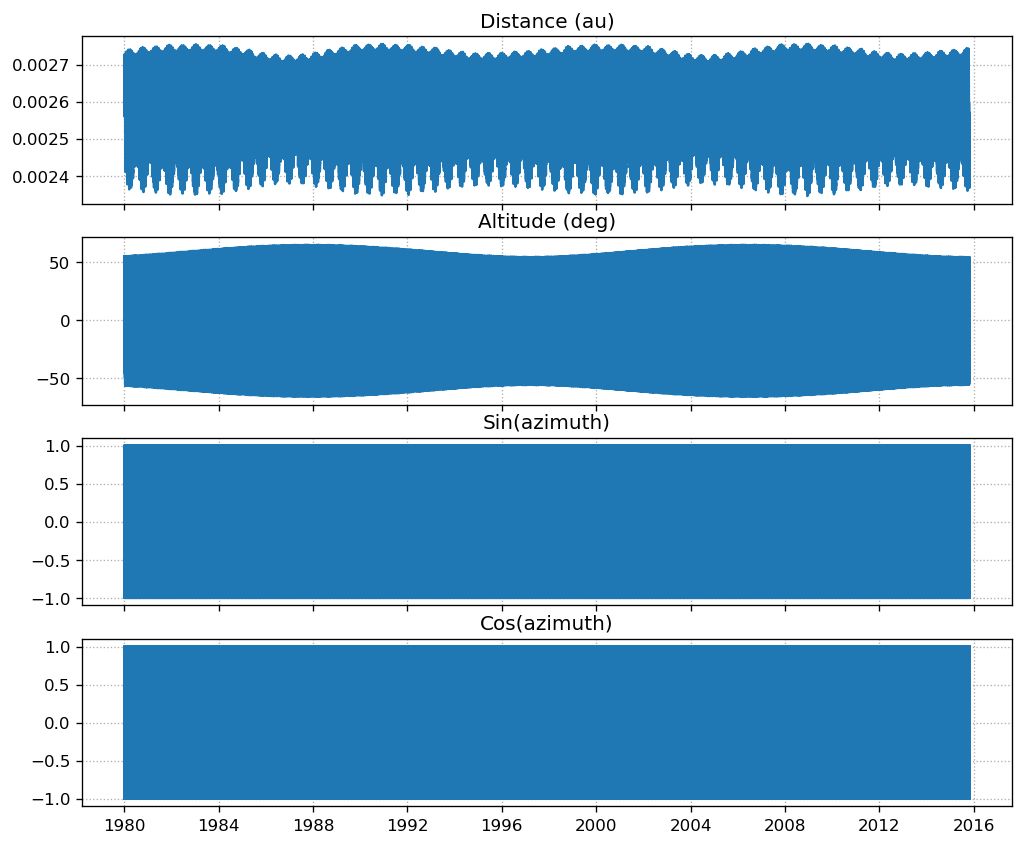

In [14]:
#
#https://en.wikipedia.org/wiki/Lunar_precession
#
fig,ax=plt.subplots(4,1,figsize=(10,8.5),dpi=120)
#
#Distance (perigee-apogee variation):
# moon at perigge aprox 356500 km = 0.002383au
# moon at apogee approx 406700 km = 0.0027186au
# so diff = 50200 km (14% of perigee)
#- 8.85y (0.000035au): Apsidal precession, rotation of moon orbit in the same direction as the Moon itself (direct motion) 
#- 205.89days approx 7 synodic months (0.0001au, mainly perigee):
#  mainly affects the perigee, due to the sun distortion of the moon path.
#  It seems that the reduction of perigee distance is related to the anomalistic month,
#  and it is enhanced when the moon is new or full. This is the reason why we have super moons.
#  If the earth and moon were the only bodies that mattered, the eccentricity would be constant.
#  But in fact the sun is also pulling on the moon, which gives this additional 7-month distance variations.
#- 27.55d anomalistic month (0.0003au)
#- 1day (0.00005au) = 6371*2/(1.496e8)*np.cos(lat/180*np.pi)
#  due to rotation of earth distance to the moon from a point on earth surface varies.
ax[0].plot(times_np,distance_moon_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#
#Altitude:
# 0 altitude when the moon is on the horizont.
#- 18.61y (10deg amp): nodal precession, i.e., rotation of the ascending node (intersection of moon orbit with ecliptic from below to above ecliptic)
#  This is related to changes in total altitude with respect to equator (declination)
#  in this interval of time moon could be between 5deg above or 5deg below eclipctic, therefore moon can reach
#  max declination 28.5 or min -28.5 (when the moon is above ecliptic (5deg) and earth below it(23.5), or visceversa)
#  max 18.5 or min -18.5 (when the moon is above ecliptic and earth also above it, or visceversa)
#- 27.21d draconic or nodal month: moon can go from -28.5:28.5 or -18.5:18.5 (with respect to eclipctic) due to moon orbit
#- 1day(75deg = 2*(90-lat=53) range), related to lunar day.
#So, taking into account that we are in 53N, max min values of altitude:
#    for lunar "summer" 90-[53-28.5]=65.5       (or 55.5 with 18.5)
#    for lunar "winter" -[90-[53-28.5]]=-65.5   (or -55.5 with 18.5)
ax[1].plot(times_np,altitude_moon_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#
#Azimuth:
#  needs cos and sin since ang[0-360] is discontinuous
#- 1 draconic or nodal month: every 13.5day the shape of the azimuth function change because
#  the day based on the moon 24.84d (like the solar day of 24h) last longer than the night when we are in  moon "summer" (high altitudes)
#  this creates a lag after 1 period with respect to 24h (like M2 tide)
#- 1day
ax[2].plot(times_np,np.sin(azimuth_moon_deg/180*np.pi))
ax[2].grid(ls=":");ax[2].set_title("Sin(azimuth)");ax[2].set_xticklabels("");
ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");
#
#However, according to FFT seems that there are more periods involve (see below cells)

(3652.0, 3666.0)

/export/lv4/user/jfajardourbina/programs/miniconda3/envs/phd_parcelsv230/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


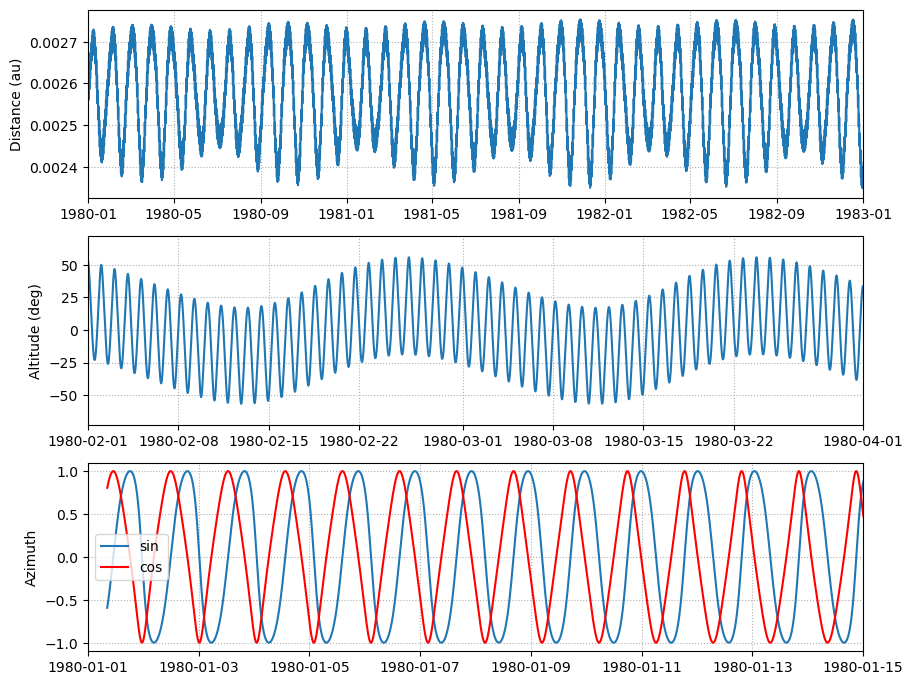

In [59]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=100)
#
ax[0].plot(times_np,distance_moon_au)  
ax[0].grid(ls=":");ax[0].set_ylabel("Distance (au)")
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1983-01-01"))
#
ax[1].plot(times_np,altitude_moon_deg)  
ax[1].grid(ls=":");ax[1].set_ylabel("Altitude (deg)")
ax[1].set_xlim(np.datetime64("1980-02-01"),np.datetime64("1980-04-01"))
#
#ax[2].plot(times_np,azimuth_moon_deg/360*24) 
ax[2].plot(times_np,np.sin(azimuth_moon_deg/180*np.pi),label="sin")  
ax[2].grid(ls=":");ax[2].set_ylabel("Azimuth")
ax[2].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi),c='r',label="cos")   
ax[2].legend()
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-15"))

In [67]:
#FFT----

In [23]:
n=len(times);  #1/24 days
freq=fftt.fftfreq(n, dt)[1:n//2+1]
#freq2 =np.arange(n//2+1)[1:]/(n*dtt) #the same as above
per=1/freq

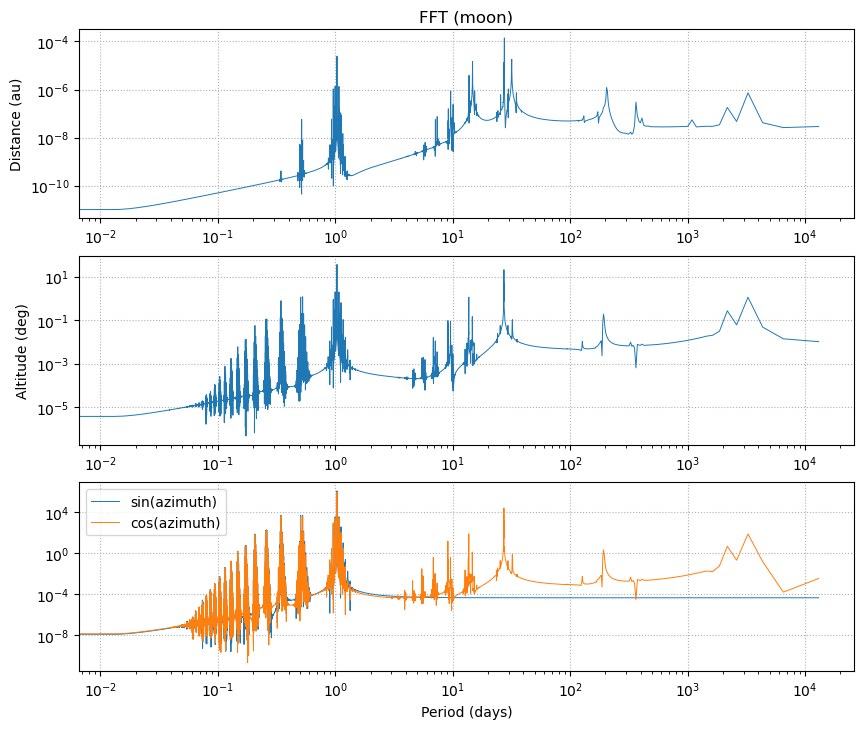

In [66]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=100)
yf=(np.abs(fftt.fft(distance_moon_au))[:n//2+1]/n)[1:] #here we are selecting half the spectra from high freq to low only, and excluding first coefficient =avg
ax[0].loglog(1/freq,2*yf,'-',ms=2,lw=.7);ax[0].grid(ls=":");ax[0].set_ylabel("Distance (au)");ax[0].set_title("FFT (moon)")
yf=(np.abs(fftt.fft(altitude_moon_deg))[:n//2+1]/n)[1:]
ax[1].loglog(1/freq,2*yf,'-',ms=2,lw=.7);ax[1].grid(ls=":");ax[1].set_ylabel("Altitude (deg)")
yf=(np.abs(fftt.fft(np.sin(azimuth_moon_deg/180*np.pi)))[:n//2+1]**2/n)[1:]
ax[2].loglog(1/freq,2*yf,'-',ms=2,lw=.7,label="sin(azimuth)");ax[2].grid(ls=":");ax[2].set_xlabel("Period (days)");
yf=(np.abs(fftt.fft(np.cos(azimuth_moon_deg/180*np.pi)))[:n//2+1]**2/n)[1:]
ax[2].loglog(1/freq,2*yf,'-',ms=2,lw=.7,label="cos(azimuth)");ax[2].grid(ls=":");ax[2].set_xlabel("Period (days)");
ax[2].legend()

In [15]:
## circular mean and std of angles (without taking into account the magnitude of vector)
##https://en.wikipedia.org/wiki/Directional_statistics#The_fundamental_difference_between_linear_and_circular_statistics

def circ_mean_std(var,units="deg",axis=-1):
    
    if units=="deg":
        fac=np.pi/180.
    else:
        fac=1.
    var=var*fac
    
    #mean
    sin_mean = np.mean(np.sin(var),axis=axis); cos_mean = np.mean(np.cos(var),axis=axis)
    var_mean = np.arctan2(sin_mean,cos_mean) #=np.arctan2(y,x), y/x=tan(angle)
    #if type(var).__name__  == "ndarray": print("this is an array")
    
    #std
    var_std=np.minimum(1.,sin_mean**2+cos_mean**2) #to avoid round issues
    var_std=(-np.log(var_std))**.5
    
    if units=="deg":
        var_mean/=fac; var_std/=fac
    
    return var_mean, var_std

#and check with scipy
from scipy.stats import circmean,circstd

In [23]:
#reshape variables---
#(nt_dep,nt_interval)
distance_moon_au_re=np.reshape(distance_moon_au,(nt_dep,nt_interval))
altitude_moon_deg_re=np.reshape(altitude_moon_deg,(nt_dep,nt_interval))
azimuth_moon_deg_re=np.reshape(azimuth_moon_deg,(nt_dep,nt_interval))

In [24]:
mean_distance_moon_au, std_distance_moon_au = np.mean(distance_moon_au_re,axis=-1), np.std(distance_moon_au_re,axis=-1)
mean_altitude_moon_deg, std_altitude_moon_deg = circ_mean_std(altitude_moon_deg_re)
mean_azimuth_moon_deg, std_azimuth_moon_deg = circ_mean_std(azimuth_moon_deg_re)
#
#the same as above using scipy:
# mean_altitude_moon_deg2, std_altitude_moon_deg2 = circmean(altitude_moon_deg_re*np.pi/180,axis=-1),circstd(altitude_moon_deg_re*np.pi/180,axis=-1)
# mean_altitude_moon_deg2*=180/np.pi; std_altitude_moon_deg2*=180/np.pi
# a=mean_altitude_moon_deg-mean_altitude_moon_deg2
# b=std_altitude_moon_deg-std_altitude_moon_deg2
# a.min(),a.max(),b.min(),b.max()

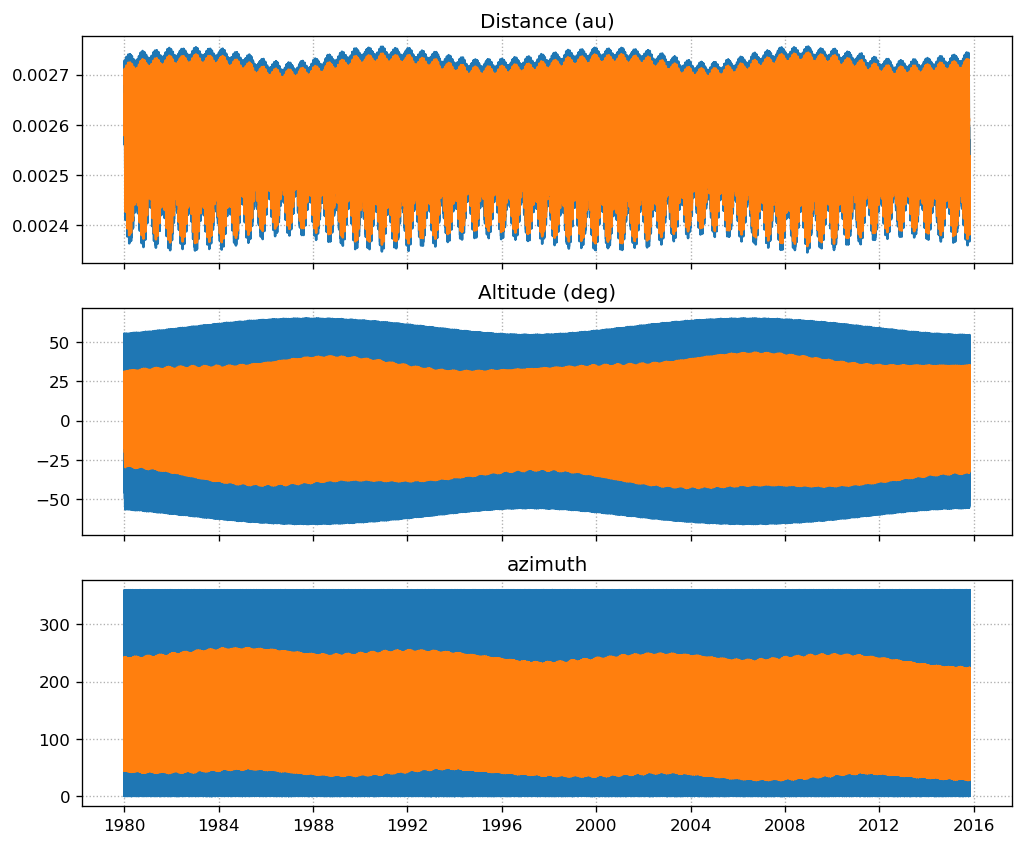

In [25]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),mean_distance_moon_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),mean_altitude_moon_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
#convert azimuth from -180:180
#azimuth_moon_deg2=azimuth_moon_deg*1.
#azimuth_moon_deg2[azimuth_moon_deg2>180]=azimuth_moon_deg2[azimuth_moon_deg2>180]-360
#ax[2].plot(times_np,azimuth_moon_deg2)
#ax[2].plot(times_np[nt_interval:nt_interval*2],azimuth_moon_deg2[nt_interval:nt_interval*2],"-o",ms=2)
#ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),azimuth_moon_deg2,"-o")
#
#convert azimuth from 0:360
mean_azimuth_moon_deg2=mean_azimuth_moon_deg*1.
mean_azimuth_moon_deg2[mean_azimuth_moon_deg2<0]=mean_azimuth_moon_deg2[mean_azimuth_moon_deg2<0]+360
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),mean_azimuth_moon_deg2)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

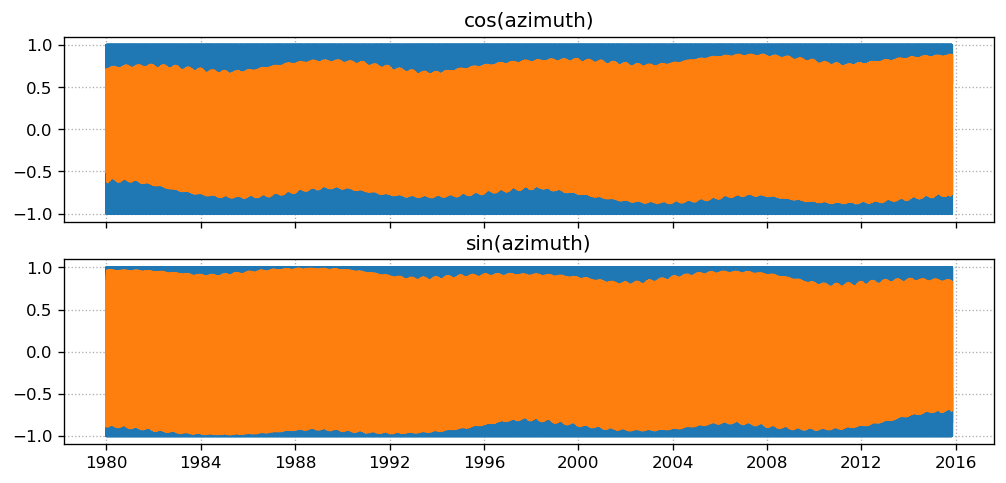

In [26]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),np.cos(mean_azimuth_moon_deg2/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_moon_deg/180*np.pi))
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),np.sin(mean_azimuth_moon_deg2/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

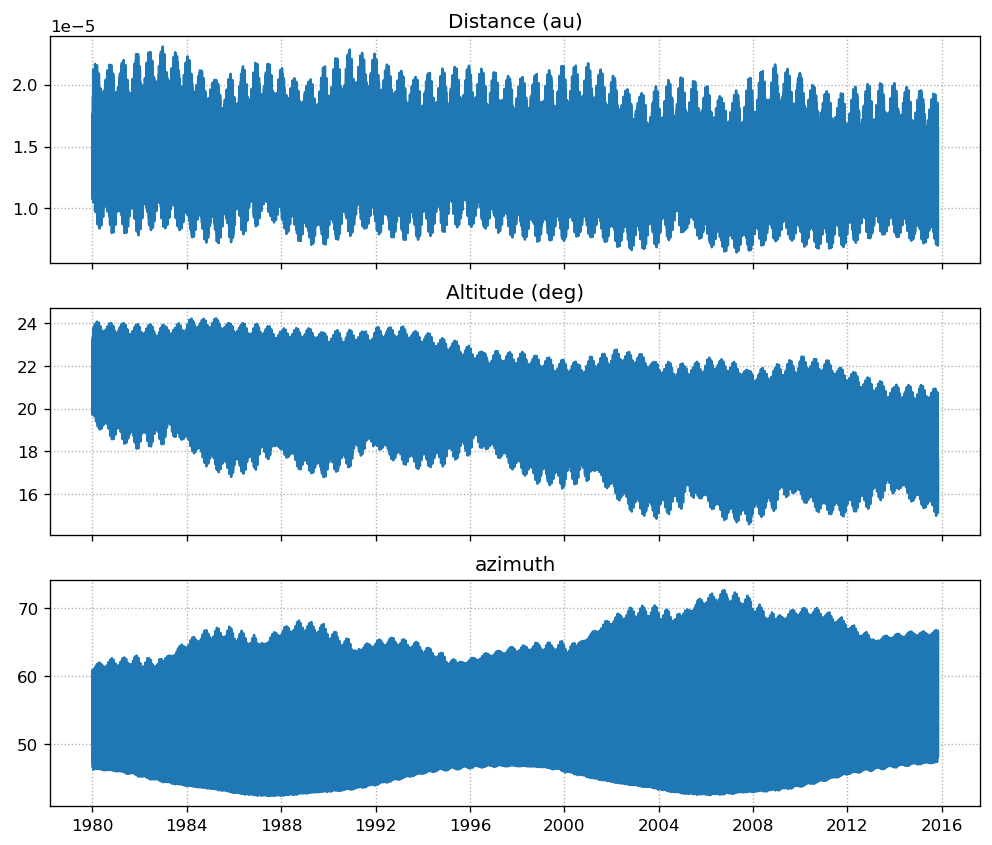

In [140]:
#now we observe the opposite behaviour for the std in comparison with the mean:
# - std_distance: negative tendency (is slightly positive for the mean)
# - sdt_altitude: negative tendency (the opposite for the mean)
# - sdt_azimuth: positive tendency (the opposite for the mean)
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
#ax[0].plot(times_np,distance_moon_au)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),std_distance_moon_au)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
#ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),std_altitude_moon_deg)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),std_azimuth_moon_deg)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

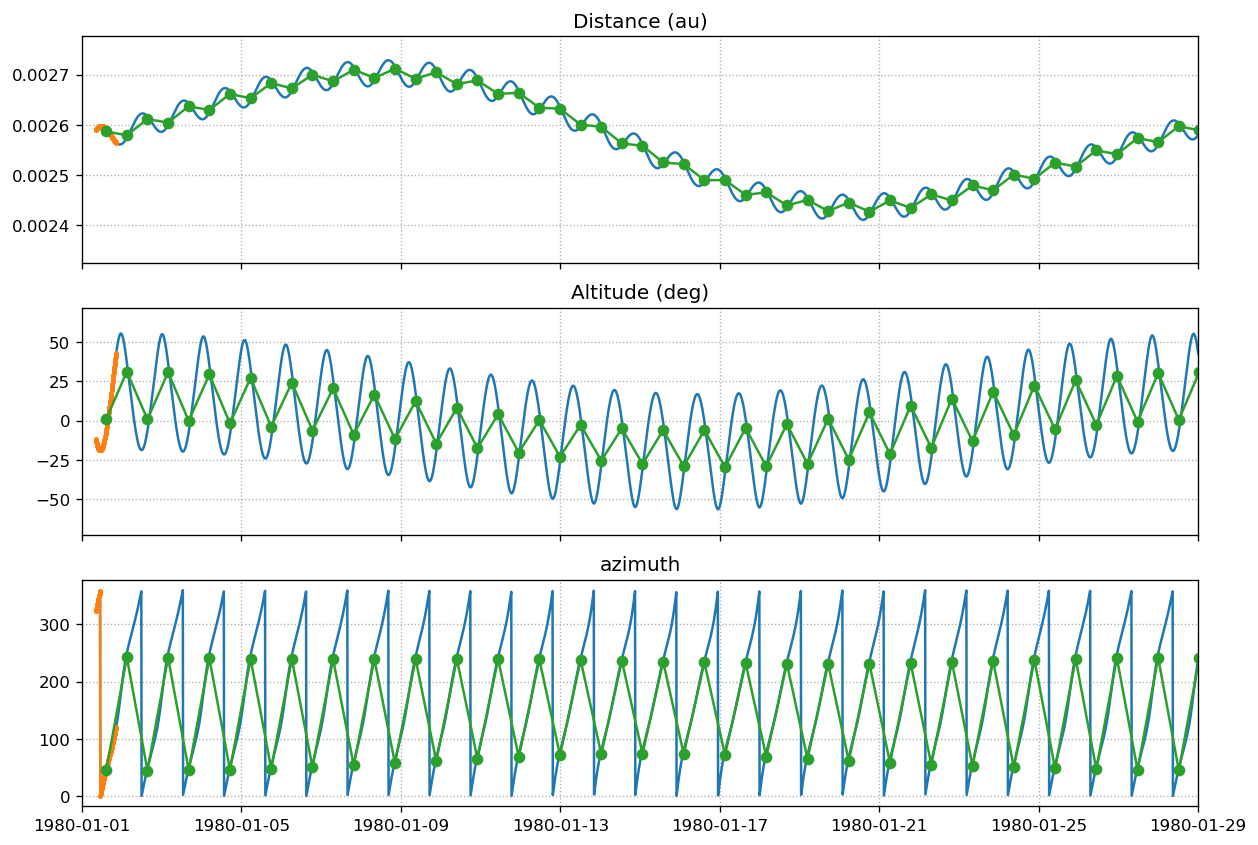

In [195]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(times_np[:nt_interval],distance_moon_au[:nt_interval],"-o",ms=2)
ax[0].plot(time_dis+np.timedelta64(m2//2,"s"),mean_distance_moon_au,"-o")
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(times_np[:nt_interval],altitude_moon_deg[:nt_interval],"-o",ms=2)
ax[1].plot(time_dis+np.timedelta64(m2//2,"s"),mean_altitude_moon_deg,"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
#convert azimuth from -180:180
#azimuth_moon_deg2=azimuth_moon_deg*1.
#azimuth_moon_deg2[azimuth_moon_deg2>180]=azimuth_moon_deg2[azimuth_moon_deg2>180]-360
#ax[2].plot(times_np,azimuth_moon_deg2)
#ax[2].plot(times_np[nt_interval:nt_interval*2],azimuth_moon_deg2[nt_interval:nt_interval*2],"-o",ms=2)
#ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),azimuth_moon_deg2,"-o")
#
#convert azimuth from 0:360
mean_azimuth_moon_deg2=mean_azimuth_moon_deg*1.
mean_azimuth_moon_deg2[mean_azimuth_moon_deg2<0]=mean_azimuth_moon_deg2[mean_azimuth_moon_deg2<0]+360
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(times_np[:nt_interval],azimuth_moon_deg[:nt_interval],"-o",ms=2)
ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),mean_azimuth_moon_deg2,"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

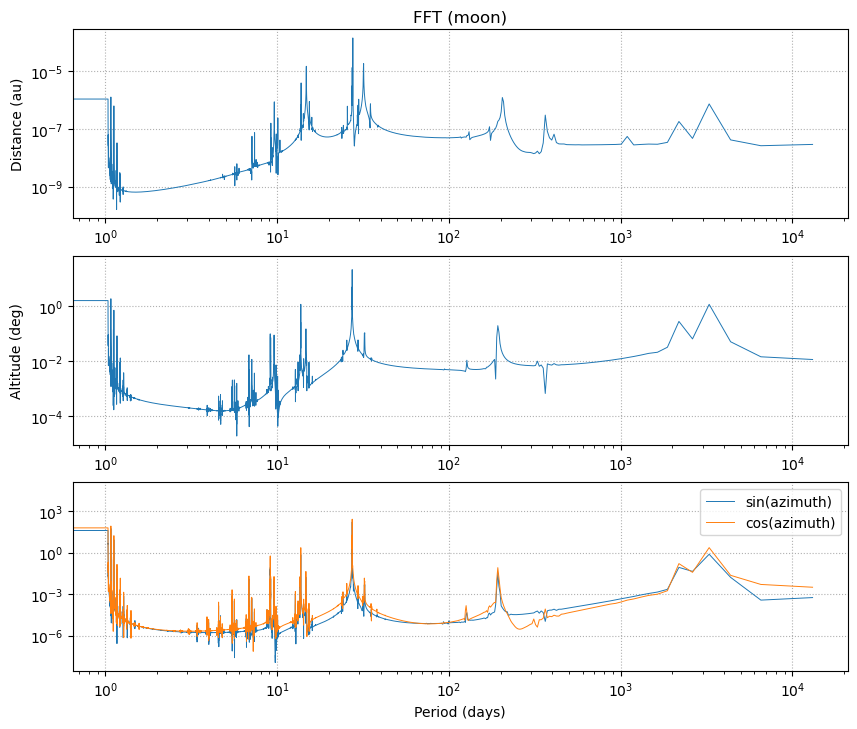

In [146]:
#FFT---
#
n=len(time_dis);  #1/24 days
freq=fftt.fftfreq(n, m2/86400)[1:n//2+1]
#freq2 =np.arange(n//2+1)[1:]/(n*dtt) #the same as above
per=1/freq
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=100)
yf=(np.abs(fftt.fft(mean_distance_moon_au))[:n//2+1]/n)[1:] #here we are selecting half the spectra from high freq to low only, and excluding first coefficient =avg
ax[0].loglog(1/freq,2*yf,'-',ms=2,lw=.7);ax[0].grid(ls=":");ax[0].set_ylabel("Distance (au)");ax[0].set_title("FFT (moon)")
yf=(np.abs(fftt.fft(mean_altitude_moon_deg))[:n//2+1]/n)[1:]
ax[1].loglog(1/freq,2*yf,'-',ms=2,lw=.7);ax[1].grid(ls=":");ax[1].set_ylabel("Altitude (deg)")
yf=(np.abs(fftt.fft(np.sin(mean_azimuth_moon_deg/180*np.pi)))[:n//2+1]**2/n)[1:]
ax[2].loglog(1/freq,2*yf,'-',ms=2,lw=.7,label="sin(azimuth)");ax[2].grid(ls=":");ax[2].set_xlabel("Period (days)");
yf=(np.abs(fftt.fft(np.cos(mean_azimuth_moon_deg/180*np.pi)))[:n//2+1]**2/n)[1:]
ax[2].loglog(1/freq,2*yf,'-',ms=2,lw=.7,label="cos(azimuth)");ax[2].grid(ls=":");ax[2].set_xlabel("Period (days)");
ax[2].legend()

In [90]:
p1=12.42060120/24; #m2
p2=27.212220815 #draconic or nodal month
p3=27.321661554 #sideral month
p4=27.321582252 #tropical month
p5=27.554549886 #anomalistic month
p6=29.530588861 #synodic month
p7=205.89;
p8=365.25;
p9=3233. #=8.85y apsidal precession = 1/(1/p5-1/p3) when the sideral and anomalistic months are in phase
p10=6793.476 #18.6y nodal precession = 1/(1/p2-1/p3) when the sideral and nodal months are in phase
p11=p6/2 #lunar phases

#number of m2 periods in a nodal cycle: 
1./(1./p2-1./p3)/p1

13126.855382421814

### The same as above, but starting from 21 steps ahead t0 = 21xdt = 21x566 = 3.3h

In [ ]:
#- now we can mainly see the negative trend in the azimuth
#- more contrast between sine and cos of the azimuth

In [196]:
#reshape variables---
nn=21 #start from initial value
#(nt_dep-1,nt_interval)
distance_moon_au_re2=np.reshape(distance_moon_au[nn:len(distance_moon_au)-nt_interval+nn],(nt_dep-1,nt_interval))
altitude_moon_deg_re2=np.reshape(altitude_moon_deg[nn:len(distance_moon_au)-nt_interval+nn],(nt_dep-1,nt_interval))
azimuth_moon_deg_re2=np.reshape(azimuth_moon_deg[nn:len(distance_moon_au)-nt_interval+nn],(nt_dep-1,nt_interval))
#
mean_distance_moon_au2, std_distance_moon_au2 = np.mean(distance_moon_au_re2,axis=-1), np.std(distance_moon_au_re2,axis=-1)
mean_altitude_moon_deg2, std_altitude_moon_deg2 = circ_mean_std(altitude_moon_deg_re2)
mean_azimuth_moon_deg2, std_azimuth_moon_deg2 = circ_mean_std(azimuth_moon_deg_re2)

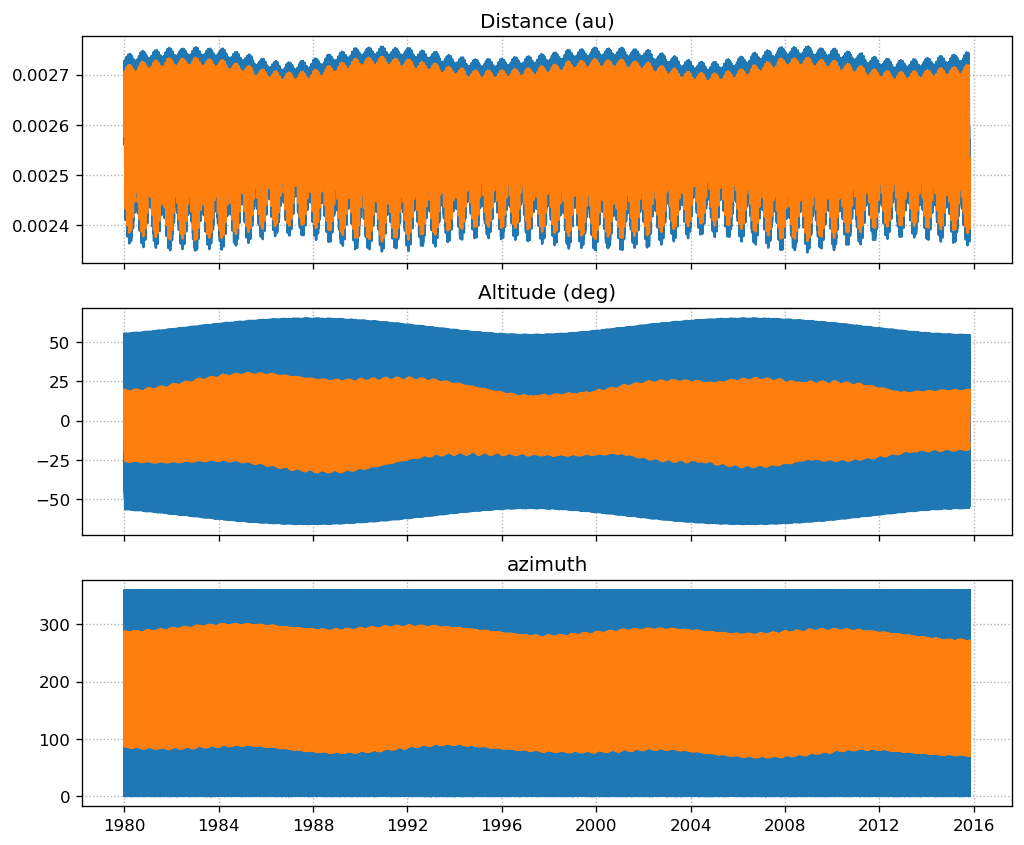

In [197]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_distance_moon_au2)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_altitude_moon_deg2)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
mean_azimuth_moon_deg2b=mean_azimuth_moon_deg2*1.
mean_azimuth_moon_deg2b[mean_azimuth_moon_deg2b<0]=mean_azimuth_moon_deg2b[mean_azimuth_moon_deg2b<0]+360
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_azimuth_moon_deg2b)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

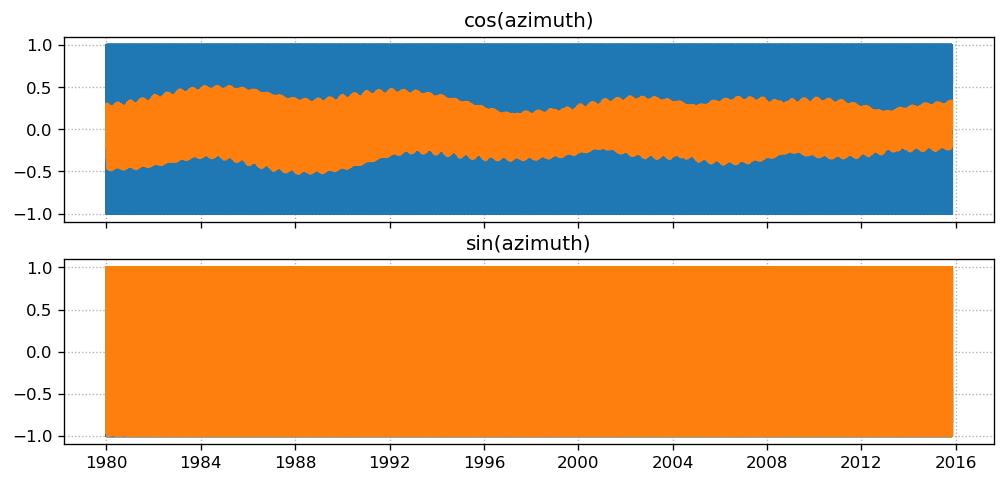

In [198]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
ax[0].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),np.cos(mean_azimuth_moon_deg2b/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_moon_deg/180*np.pi))
ax[1].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),np.sin(mean_azimuth_moon_deg2b/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

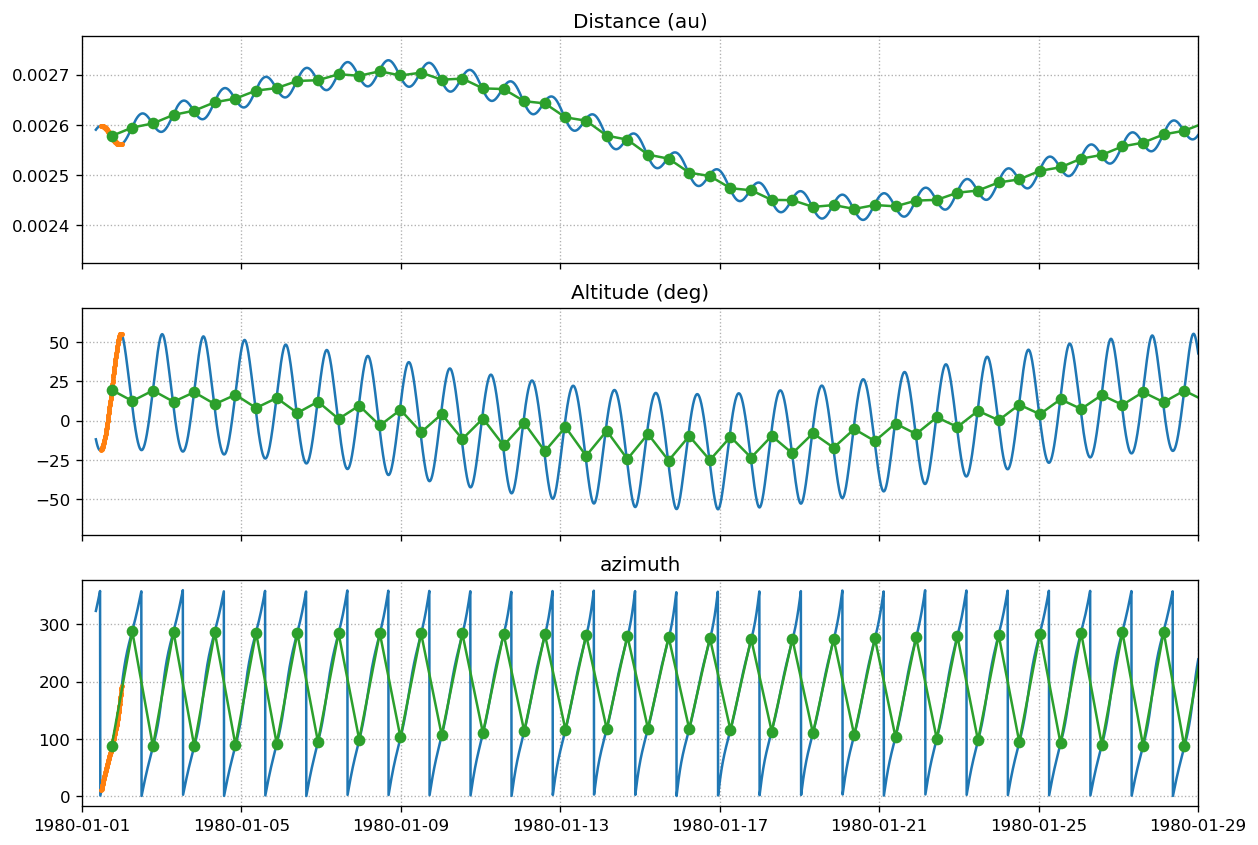

In [199]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(times_np[nn:nt_interval+nn],distance_moon_au[nn:nt_interval+nn],"-o",ms=2)
ax[0].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_distance_moon_au2,"-o")
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(times_np[nn:nt_interval+nn],altitude_moon_deg[nn:nt_interval+nn],"-o",ms=2)
ax[1].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_altitude_moon_deg2,"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(times_np[nn:nt_interval+nn],azimuth_moon_deg[nn:nt_interval+nn],"-o",ms=2)
ax[2].plot(time_dis[:-1]+np.timedelta64(m2//2+nn*dt_fac_m2_sec,"s"),mean_azimuth_moon_deg2b,"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

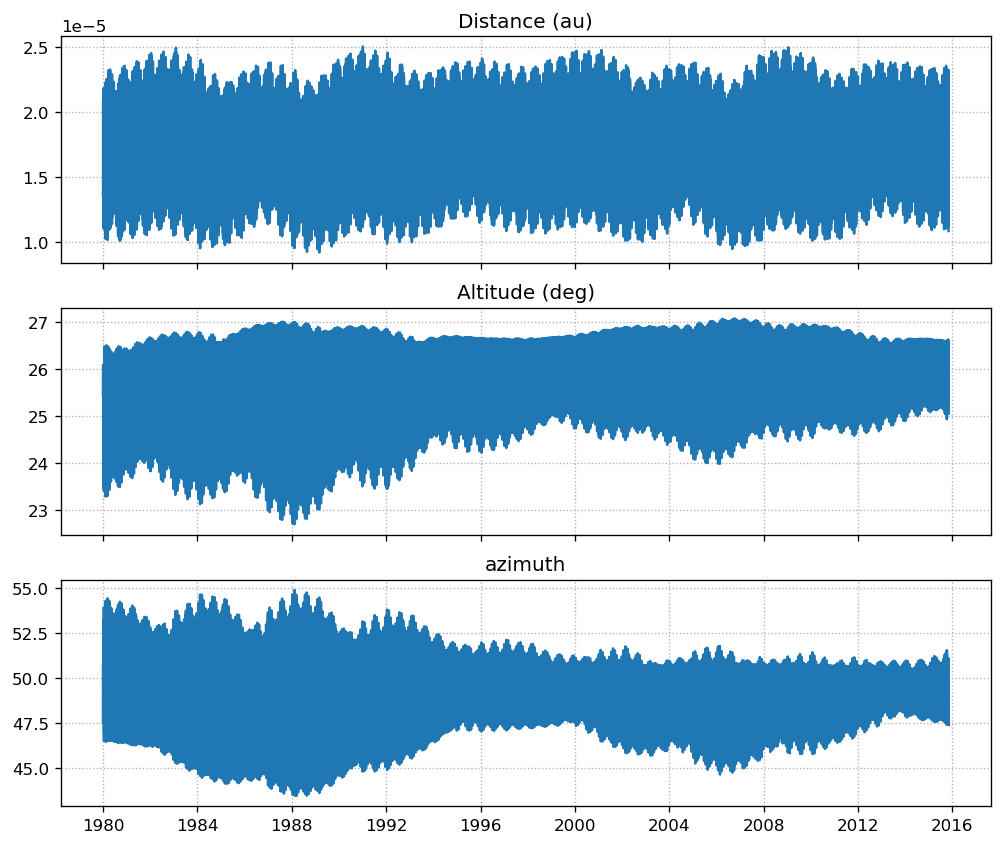

In [44]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
#ax[0].plot(times_np,distance_moon_au)
ax[0].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),std_distance_moon_au2)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
#ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),std_altitude_moon_deg2)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
ax[2].plot(time_dis[:-1]+np.timedelta64(m2//2+nn,"s"),std_azimuth_moon_deg2)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

### Taking values every M2

In [ ]:
#we can see that if we just take values every M2, we get the same behaviour as the original M2-avg:
#a not clear 18.6y cycle for altitude, a negative trend for mean azimuth, and partly remove the effect of m2 because signals have 2xm2 periodicity

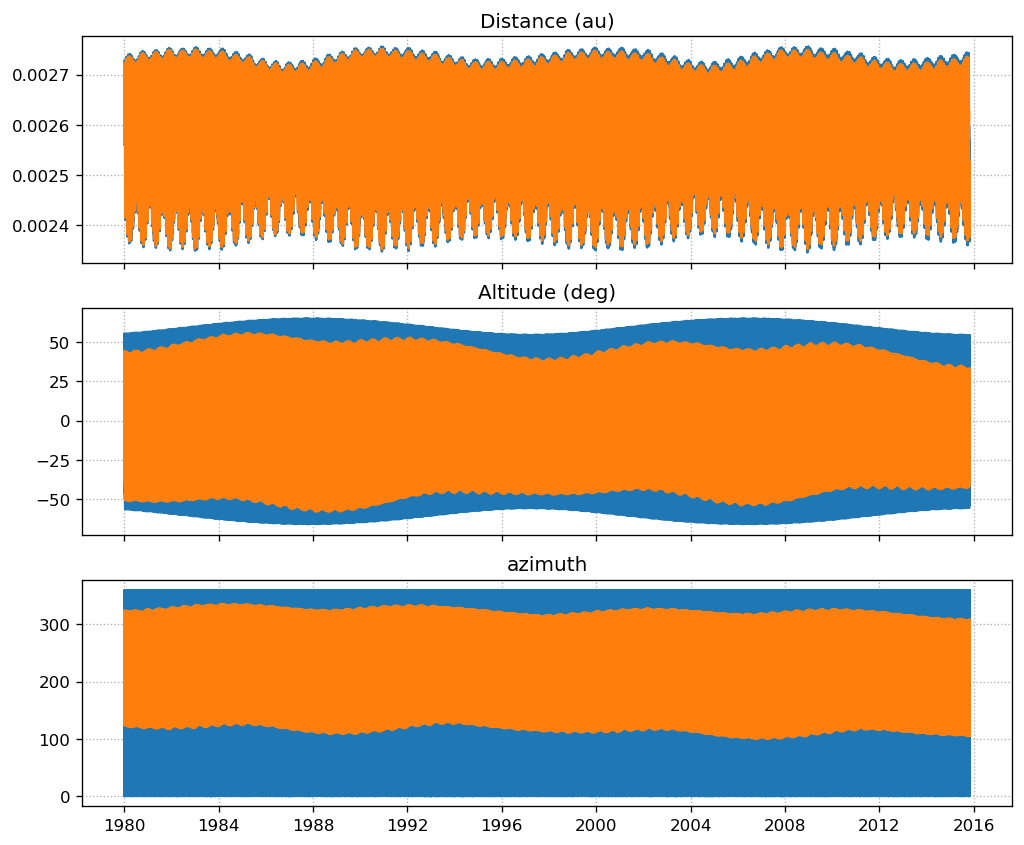

In [200]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(times_np[::nt_interval],distance_moon_au[::nt_interval])
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(times_np[::nt_interval],altitude_moon_deg[::nt_interval])
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(times_np[::nt_interval],azimuth_moon_deg[::nt_interval])
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

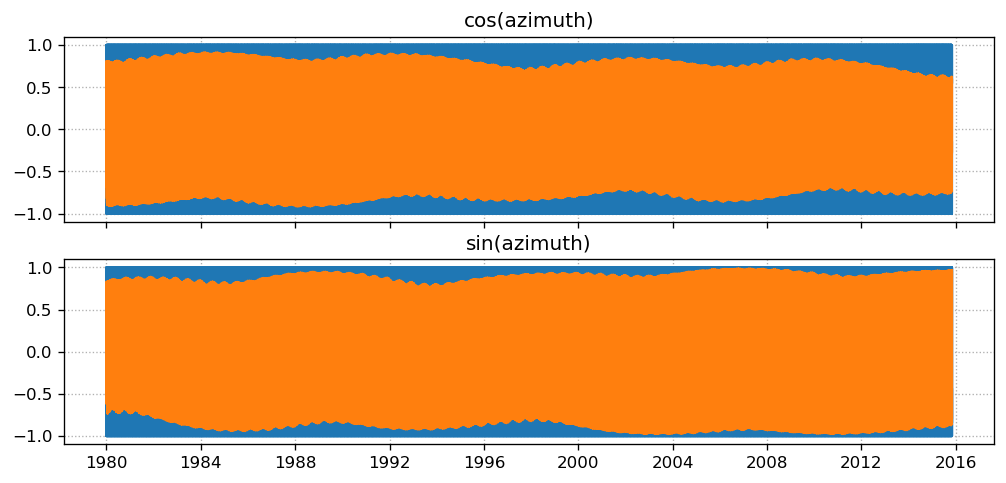

In [133]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
ax[0].plot(times_np[::nt_interval],np.cos(azimuth_moon_deg[::nt_interval]/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_moon_deg/180*np.pi))
ax[1].plot(times_np[::nt_interval],np.sin(azimuth_moon_deg[::nt_interval]/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

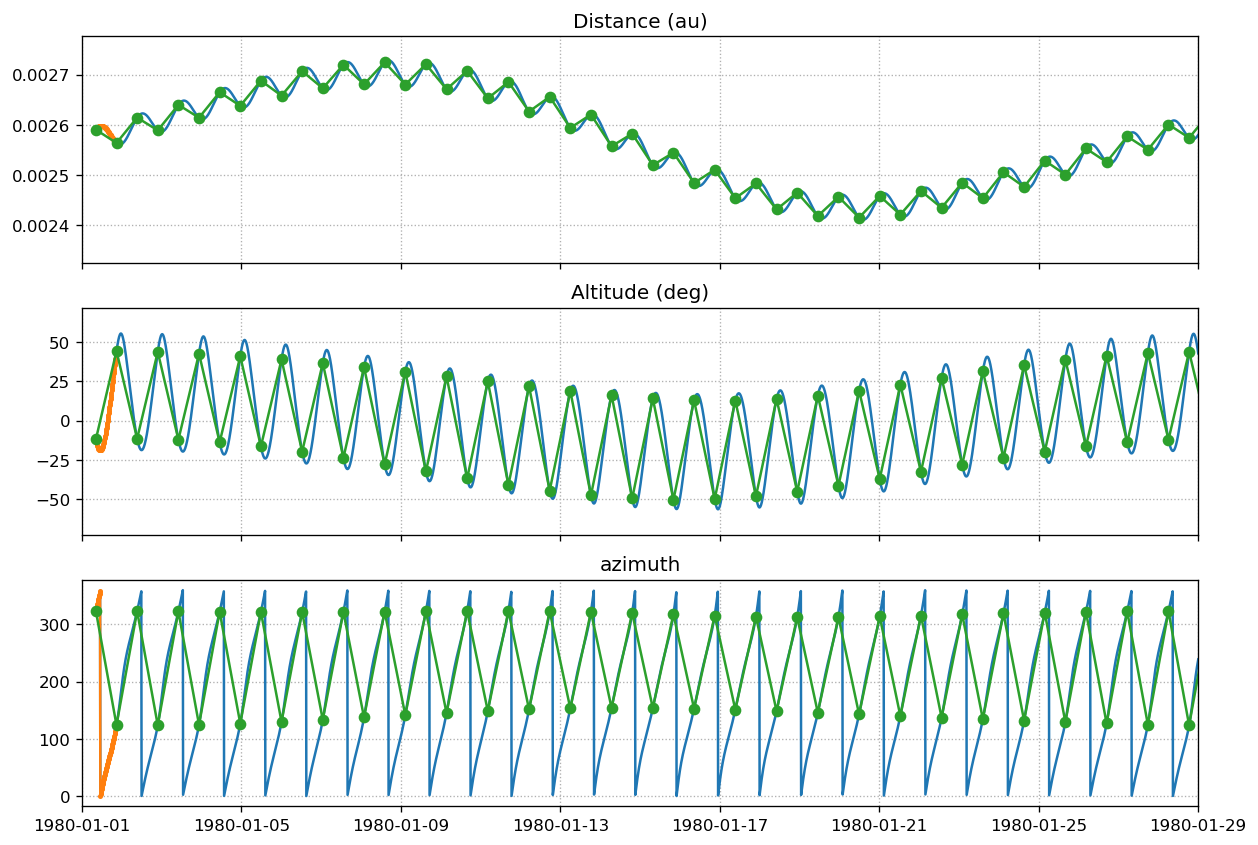

In [201]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(times_np[:nt_interval],distance_moon_au[:nt_interval],"-o",ms=2)
ax[0].plot(times_np[::nt_interval],distance_moon_au[::nt_interval],"-o")
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(times_np[:nt_interval],altitude_moon_deg[:nt_interval],"-o",ms=2)
ax[1].plot(times_np[::nt_interval],altitude_moon_deg[::nt_interval],"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(times_np[:nt_interval],azimuth_moon_deg[:nt_interval],"-o",ms=2)
ax[2].plot(times_np[::nt_interval],azimuth_moon_deg[::nt_interval],"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

### Taking values every M2, but starting 21 steps ahead

In [128]:
ni=21 #start from here
nn=1 #select data every nt_interval/nn, if nn=1 just selecte every m2
nt_interval,m2/nn/3600

(79, 12.420555555555556)

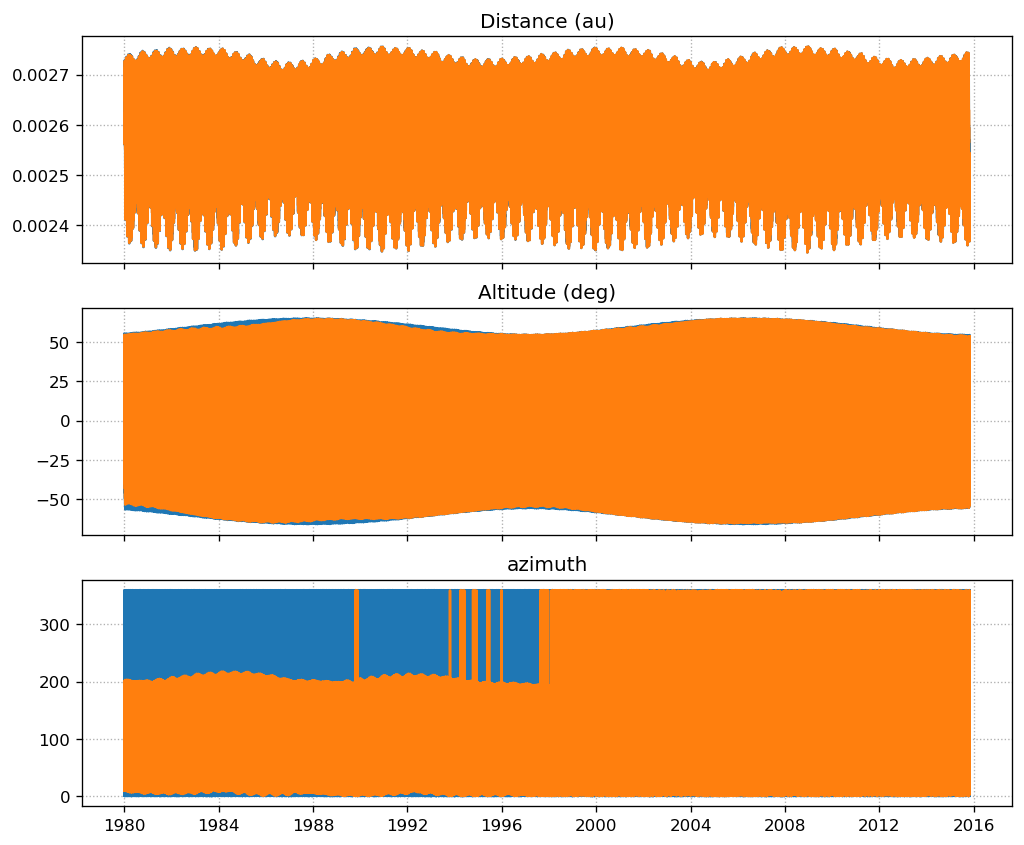

In [129]:
#
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(times_np[ni::nt_interval//nn],distance_moon_au[ni::nt_interval//nn])
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(times_np[ni::nt_interval//nn],altitude_moon_deg[ni::nt_interval//nn])
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1983-01-01"))
#Azimuth:
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(times_np[ni::nt_interval//nn],azimuth_moon_deg[ni::nt_interval//nn])
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

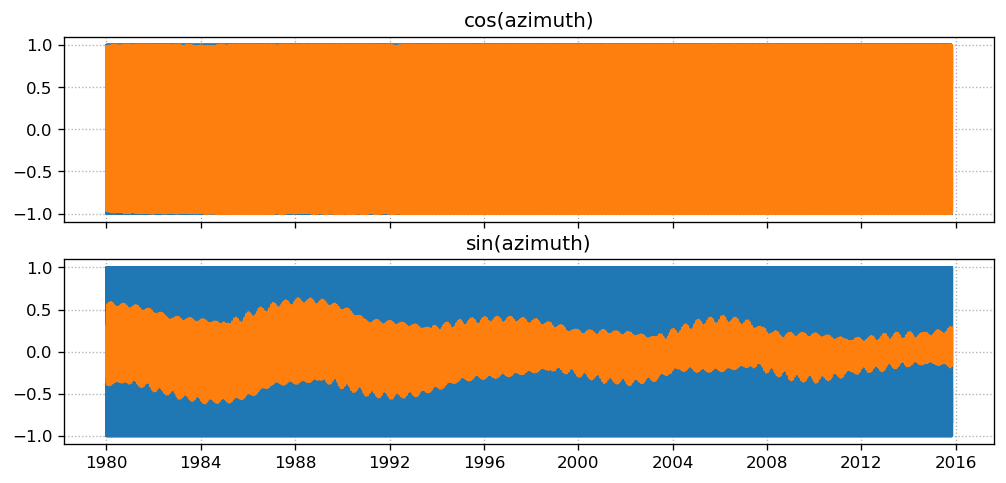

In [131]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
ax[0].plot(times_np[ni::nt_interval//nn],np.cos(azimuth_moon_deg[ni::nt_interval//nn]/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_moon_deg/180*np.pi))
ax[1].plot(times_np[ni::nt_interval//nn],np.sin(azimuth_moon_deg[ni::nt_interval//nn]/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

### using data every m2 with more accuracy (not average)

In [173]:
#create a time vector with skyfield--- 
m2_long=12.42060120*3600
#lag in hours after 36years between our m2 and the actual m2:
print(36*364.24/p1*(m2_long-m2)/3600)

#find total seconds between init and final date:
ti=datetime.datetime(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
te=datetime.datetime(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
tot_sec=(te-ti).total_seconds() #total elapsed seconds
#
#build Time objects from an UTC calendar date, using the init UTC date and the elapsed seconds since this initial date
times2=ts.utc(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,np.arange(tinip.second,tot_sec+1e-5,m2_long))
dtt=np.diff(times.tt) #=dt=9.43min
print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times.shape)
#
print(tinip,times2[[0,1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
print(tendp,times2[[-2,-1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
np.sum(np.diff(times.tt))*86400,(times[-1].tt-times[0].tt)*86400,m2_long*(len(times)-1)

#using numpy (it does not take into account leap seconds), but the size of the array is the same as skyfield
#the elapsed time is also the same
times_np2=np.arange(tini,tend+np.timedelta64(1,'s'),int(m2_long*1e9),dtype='datetime64[ns]') 
print(times_np2,times_np2.shape)

1.1565027973288373
566 565.9999877214432 565.9999999999953 566.0000279545784 (1997910,)
1980-01-01 08:20:00 ['1980-01-01 08:20:00', '1980-01-01 20:45:14']
2015-11-01 12:01:34 ['2015-10-31 12:29:30', '2015-11-01 00:54:44']
['1980-01-01T08:20:00.000000000' '1980-01-01T20:45:14.164320000'
 '1980-01-02T09:10:28.328640000' ... '2015-10-31T00:04:33.159840000'
 '2015-10-31T12:29:47.324160000' '2015-11-01T00:55:01.488480000'] (25290,)


In [174]:
%%time
#MOON----
astro_moon = dws.at(times2).observe(moon)
alt_moon2, az_moon2, dist_moon2 = astro_moon.apparent().altaz()
print(alt_moon2)
print(az_moon2)
#print(dist_moon)
#
#convert above values to arrays---
#altitude_moon_rad=alt_moon.radians
altitude_moon_deg2=alt_moon2.degrees
#azimuth_moon_rad=alt_moon.radians
azimuth_moon_deg2=az_moon2.degrees
distance_moon_au2 = dist_moon2.au #AU units
#distance_moon_km = dist_moon.km #km units
#distance_moon_km2 = dist_moon2.km #km units
#a=distance_moon_km-distance_moon_km2 #almost the same distnace when using .radec
print(altitude_moon_deg2[[0,-1]])
print(azimuth_moon_deg2[[0,-1]])
print(distance_moon_au2[[0,-1]])
#print(distance_moon_km[[0,-1]])

25290 values from -11deg 54' 44.2" to 41deg 58' 43.5"
25290 values from 323deg 38' 39.0" to 121deg 40' 22.8"
[-11.91226487  41.9787506 ]
[323.64415874 121.67299119]
[0.00259017 0.00251881]
CPU times: user 30 s, sys: 1.46 s, total: 31.5 s
Wall time: 2.69 s


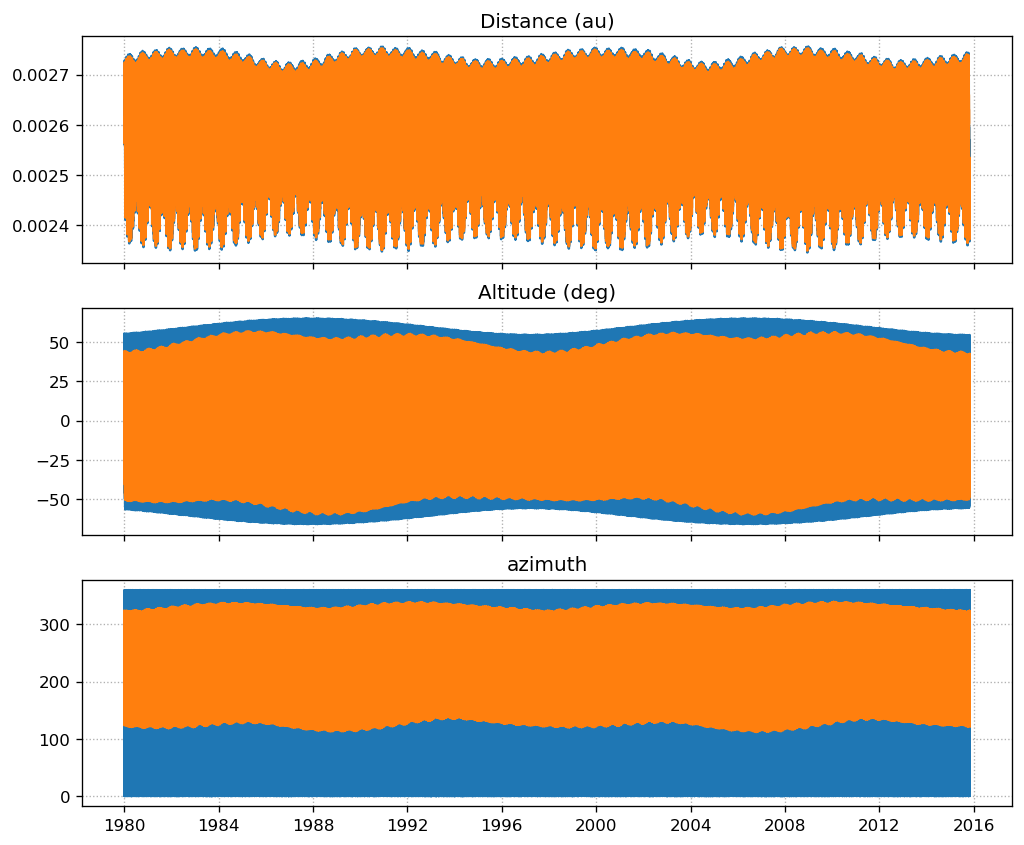

In [175]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(times_np2,distance_moon_au2)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(times_np2,altitude_moon_deg2)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
#convert azimuth from -180:180
#azimuth_moon_deg2=azimuth_moon_deg*1.
#azimuth_moon_deg2[azimuth_moon_deg2>180]=azimuth_moon_deg2[azimuth_moon_deg2>180]-360
#ax[2].plot(times_np,azimuth_moon_deg2)
#ax[2].plot(times_np[nt_interval:nt_interval*2],azimuth_moon_deg2[nt_interval:nt_interval*2],"-o",ms=2)
#ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),azimuth_moon_deg2,"-o")
#
#convert azimuth from 0:360
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(times_np2,azimuth_moon_deg2)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

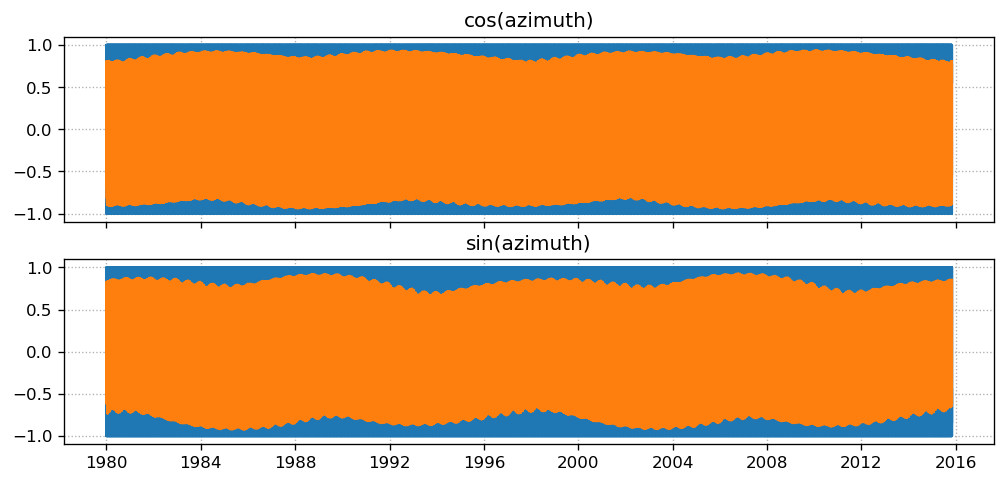

In [176]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
ax[0].plot(times_np2,np.cos(azimuth_moon_deg2/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_moon_deg/180*np.pi))
ax[1].plot(times_np2,np.sin(azimuth_moon_deg2/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

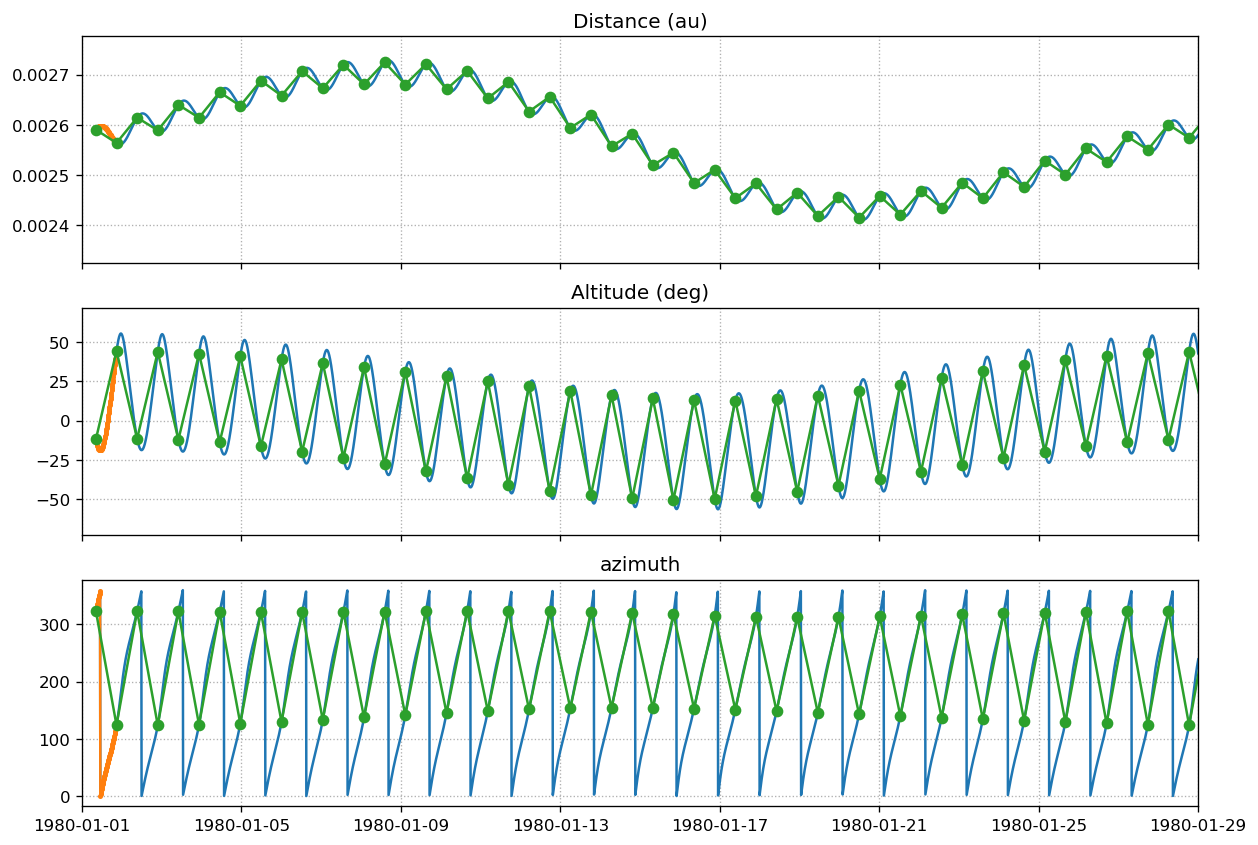

In [208]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(times_np[:nt_interval],distance_moon_au[:nt_interval],"-o",ms=2)
ax[0].plot(times_np2,distance_moon_au2,"-o")
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(times_np[:nt_interval],altitude_moon_deg[:nt_interval],"-o",ms=2)
ax[1].plot(times_np2,altitude_moon_deg2,"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
#convert azimuth from -180:180
#azimuth_moon_deg2=azimuth_moon_deg*1.
#azimuth_moon_deg2[azimuth_moon_deg2>180]=azimuth_moon_deg2[azimuth_moon_deg2>180]-360
#ax[2].plot(times_np,azimuth_moon_deg2)
#ax[2].plot(times_np[nt_interval:nt_interval*2],azimuth_moon_deg2[nt_interval:nt_interval*2],"-o",ms=2)
#ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),azimuth_moon_deg2,"-o")
#
#convert azimuth from 0:360
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(times_np[:nt_interval],azimuth_moon_deg[:nt_interval],"-o",ms=2)
ax[2].plot(times_np2,azimuth_moon_deg2,"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

### The same as above, but starting from 21 steps ahead t0 = 21xdt = 21x566 = 3.3h

In [209]:
#create a time vector with skyfield--- 
m2_long=12.42060120*3600
#lag in hours after 36years between our m2 and the actual m2:
print(36*364.24/p1*(m2_long-m2)/3600)
#
nn=21
tinip2=pd.to_datetime(tini+np.timedelta64(nn*dt_fac_m2_sec,'s'))  #start from nn*dt seconds = 21*566 s

#find total seconds between init and final date:
ti=datetime.datetime(tinip2.year,tinip2.month,tinip2.day,tinip2.hour,tinip2.minute,tinip2.second)
te=datetime.datetime(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
tot_sec=(te-ti).total_seconds() #total elapsed seconds
#
#build Time objects from an UTC calendar date, using the init UTC date and the elapsed seconds since this initial date
times2=ts.utc(tinip2.year,tinip2.month,tinip2.day,tinip2.hour,tinip2.minute,np.arange(tinip2.second,tot_sec+1e-5,m2_long))
dtt=np.diff(times.tt) #=dt=9.43min
print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times.shape)
#
print(tinip2,times2[[0,1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
print(tendp,times2[[-2,-1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
np.sum(np.diff(times.tt))*86400,(times[-1].tt-times[0].tt)*86400,m2_long*(len(times)-1)

#using numpy (it does not take into account leap seconds), but the size of the array is the same as skyfield
#the elapsed time is also the same
times_np2=np.arange(tini+np.timedelta64(nn*dt_fac_m2_sec,'s'),tend+np.timedelta64(1,'s'),int(m2_long*1e9),dtype='datetime64[ns]') 
print(times_np2,times_np2.shape)

1.1565027973288373
566 565.9999877214432 565.9999999999953 566.0000279545784 (1997910,)
1980-01-01 11:38:06 ['1980-01-01 11:38:06', '1980-01-02 00:03:20']
2015-11-01 12:01:34 ['2015-10-31 15:47:36', '2015-11-01 04:12:50']
['1980-01-01T11:38:06.000000000' '1980-01-02T00:03:20.164320000'
 '1980-01-02T12:28:34.328640000' ... '2015-10-31T03:22:39.159840000'
 '2015-10-31T15:47:53.324160000' '2015-11-01T04:13:07.488480000'] (25290,)


In [210]:
%%time
#MOON----
astro_moon = dws.at(times2).observe(moon)
alt_moon2, az_moon2, dist_moon2 = astro_moon.apparent().altaz()
print(alt_moon2)
print(az_moon2)
#print(dist_moon)
#
#convert above values to arrays---
#altitude_moon_rad=alt_moon.radians
altitude_moon_deg2=alt_moon2.degrees
#azimuth_moon_rad=alt_moon.radians
azimuth_moon_deg2=az_moon2.degrees
distance_moon_au2 = dist_moon2.au #AU units
#distance_moon_km = dist_moon.km #km units
#distance_moon_km2 = dist_moon2.km #km units
#a=distance_moon_km-distance_moon_km2 #almost the same distnace when using .radec
print(altitude_moon_deg2[[0,-1]])
print(azimuth_moon_deg2[[0,-1]])
print(distance_moon_au2[[0,-1]])
#print(distance_moon_km[[0,-1]])

25290 values from -18deg 25' 21.2" to 53deg 58' 15.5"
25290 values from 09deg 43' 22.9" to 190deg 52' 47.0"
[-18.42254195  53.97096441]
[  9.72301623 190.87971002]
[0.00259805 0.00251866]
CPU times: user 29.2 s, sys: 1.22 s, total: 30.4 s
Wall time: 2.57 s


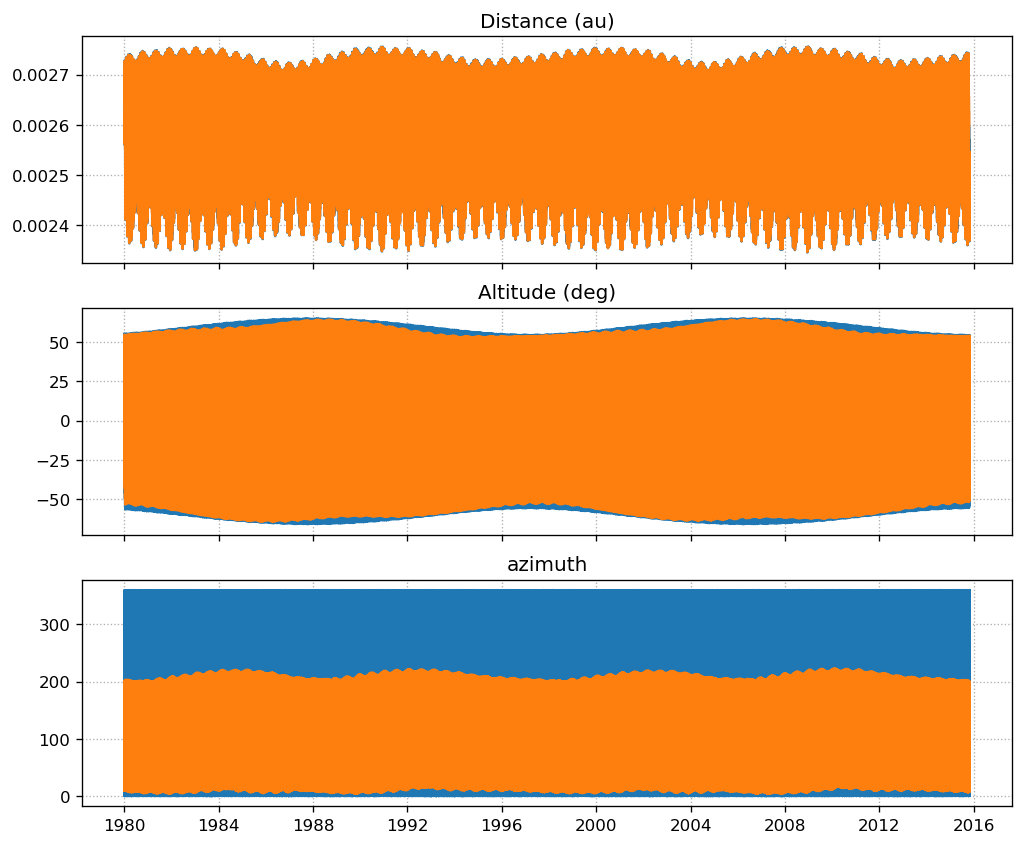

In [183]:
fig,ax=plt.subplots(3,1,figsize=(10,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(times_np2,distance_moon_au2)
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(times_np2,altitude_moon_deg2)
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
#ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"))
#Azimuth:
#convert azimuth from -180:180
#azimuth_moon_deg2=azimuth_moon_deg*1.
#azimuth_moon_deg2[azimuth_moon_deg2>180]=azimuth_moon_deg2[azimuth_moon_deg2>180]-360
#ax[2].plot(times_np,azimuth_moon_deg2)
#ax[2].plot(times_np[nt_interval:nt_interval*2],azimuth_moon_deg2[nt_interval:nt_interval*2],"-o",ms=2)
#ax[2].plot(time_dis+np.timedelta64(m2//2,"s"),azimuth_moon_deg2,"-o")
#
#convert azimuth from 0:360
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(times_np2,azimuth_moon_deg2)
ax[2].grid(ls=":");ax[2].set_title("azimuth");
#ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1996-01-01"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

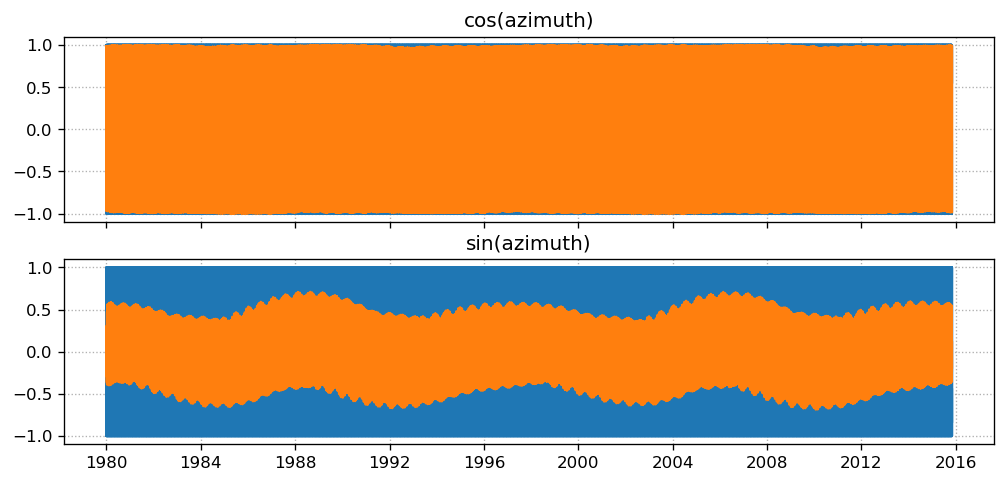

In [184]:
#
fig,ax=plt.subplots(2,1,figsize=(10,4.5),dpi=120)
#Azimuth:
ax[0].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
ax[0].plot(times_np2,np.cos(azimuth_moon_deg2/180*np.pi))
ax[0].grid(ls=":");ax[0].set_title("cos(azimuth)");ax[0].set_xticklabels("");
#ax[0].set_xlim(np.datetime64("1998-01-01"),np.datetime64("2008-01-01"));
ax[1].plot(times_np,np.sin(azimuth_moon_deg/180*np.pi))
ax[1].plot(times_np2,np.sin(azimuth_moon_deg2/180*np.pi))
ax[1].grid(ls=":");ax[1].set_title("sin(azimuth)");

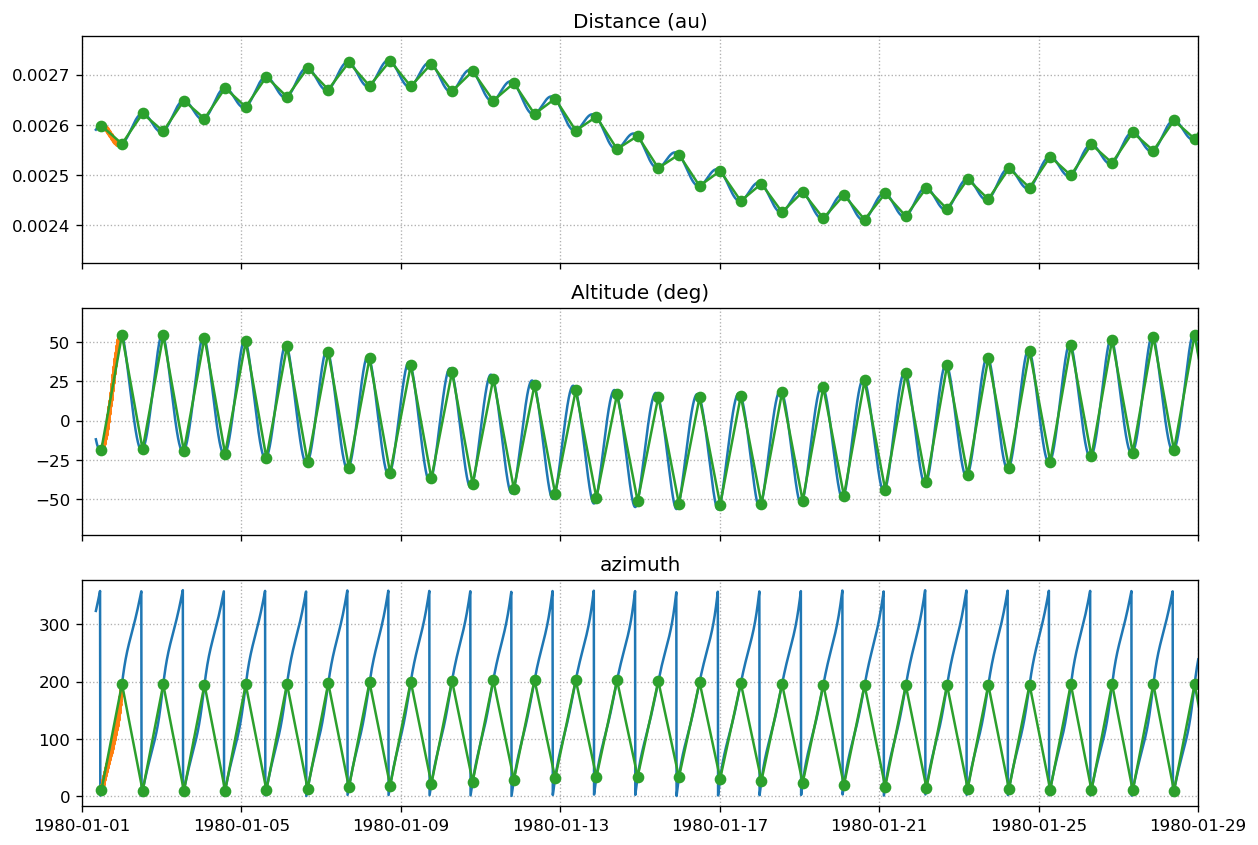

In [213]:
fig,ax=plt.subplots(3,1,figsize=(12,8.5),dpi=120)
#Distance (perigee-apogee variation):
ax[0].plot(times_np,distance_moon_au)
ax[0].plot(times_np[nn:nt_interval+nn],distance_moon_au[nn:nt_interval+nn],"-o",ms=2)
ax[0].plot(times_np2,distance_moon_au2,"-o")
ax[0].grid(ls=":");ax[0].set_title("Distance (au)");ax[0].set_xticklabels("");
ax[0].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Altitude:
ax[1].plot(times_np,altitude_moon_deg)
ax[1].plot(times_np[nn:nt_interval+nn],altitude_moon_deg[nn:nt_interval+nn],"-o",ms=2)
ax[1].plot(times_np2,altitude_moon_deg2,"-o")
ax[1].grid(ls=":");ax[1].set_title("Altitude (deg)");ax[1].set_xticklabels("");
ax[1].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"))
#Azimuth:
#convert azimuth from 0:360
ax[2].plot(times_np,azimuth_moon_deg)
ax[2].plot(times_np[nn:nt_interval+nn],azimuth_moon_deg[nn:nt_interval+nn],"-o",ms=2)
ax[2].plot(times_np2,azimuth_moon_deg2,"-o")
ax[2].grid(ls=":");ax[2].set_title("azimuth");
ax[2].set_xlim(np.datetime64("1980-01-01"),np.datetime64("1980-01-29"));
#ax[3].plot(times_np,np.cos(azimuth_moon_deg/180*np.pi))
#ax[3].grid(ls=":");ax[3].set_title("Cos(azimuth)");

### using data every m2 (not average), the same as original case every nt_interval

In [187]:
#create a time vector with skyfield--- 

#find total seconds between init and final date:
ti=datetime.datetime(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,tinip.second)
te=datetime.datetime(tendp.year,tendp.month,tendp.day,tendp.hour,tendp.minute,tendp.second)
tot_sec=(te-ti).total_seconds() #total elapsed seconds
#
#build Time objects from an UTC calendar date, using the init UTC date and the elapsed seconds since this initial date
times2=ts.utc(tinip.year,tinip.month,tinip.day,tinip.hour,tinip.minute,np.arange(tinip.second,tot_sec+1e-5,m2))
dtt=np.diff(times.tt) #=dt=9.43min
print(dt_fac_m2_sec,dtt.min()*86400,dtt.mean()*86400,dtt.max()*86400,times.shape)
#
print(tinip,times2[[0,1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
print(tendp,times2[[-2,-1]].utc_strftime('%Y-%m-%d %H:%M:%S'))
np.sum(np.diff(times.tt))*86400,(times[-1].tt-times[0].tt)*86400,m2*(len(times)-1)

#using numpy (it does not take into account leap seconds), but the size of the array is the same as skyfield
#the elapsed time is also the same
times_np2=np.arange(tini,tend+np.timedelta64(1,'s'),int(m2*1e9),dtype='datetime64[ns]') 
print(times_np2,times_np2.shape)

#MOON----
astro_moon = dws.at(times2).observe(moon)
alt_moon2, az_moon2, dist_moon2 = astro_moon.apparent().altaz()
print(alt_moon2)
print(az_moon2)
#print(dist_moon)
#
#convert above values to arrays---
#altitude_moon_rad=alt_moon.radians
altitude_moon_deg2=alt_moon2.degrees
#azimuth_moon_rad=alt_moon.radians
azimuth_moon_deg2=az_moon2.degrees
distance_moon_au2 = dist_moon2.au #AU units
#distance_moon_km = dist_moon.km #km units
#distance_moon_km2 = dist_moon2.km #km units
#a=distance_moon_km-distance_moon_km2 #almost the same distnace when using .radec
print(altitude_moon_deg2[[0,-1]])
print(azimuth_moon_deg2[[0,-1]])
print(distance_moon_au2[[0,-1]])
#print(distance_moon_km[[0,-1]])

566 565.9999877214432 565.9999999999953 566.0000279545784 (1997910,)
1980-01-01 08:20:00 ['1980-01-01 08:20:00', '1980-01-01 20:45:14']
2015-11-01 12:01:34 ['2015-10-31 11:20:15', '2015-10-31 23:45:29']
['1980-01-01T08:20:00.000000000' '1980-01-01T20:45:14.000000000'
 '1980-01-02T09:10:28.000000000' ... '2015-10-30T22:55:18.000000000'
 '2015-10-31T11:20:32.000000000' '2015-10-31T23:45:46.000000000'] (25290,)
25290 values from -11deg 54' 44.2" to 32deg 42' 27.8"
25290 values from 323deg 38' 39.0" to 105deg 09' 25.8"
[-11.91226487  32.70772286]
[323.64415874 105.15716114]
[0.00259017 0.00252224]


In [193]:
#the same as every nt_interval
a=distance_moon_au[::nt_interval]-distance_moon_au2
b=altitude_moon_deg[::nt_interval] -altitude_moon_deg2
c=azimuth_moon_deg[::nt_interval]-azimuth_moon_deg2
np.sum(a),b.sum(),c.sum()

(0.0, 0.0, 0.0)